In [1]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Introduction to Ensemble Methods

Ensemble methods are techniques for obtaining better predictive performances by using multiple models.

To get an overview of the methods we are going to see today, you can watch this video of Machine learnia about Ensemble learning : https://www.youtube.com/watch?v=7C_YpudYtw8 (you don't need to understand everything before beginning the notebook ;)).

The following dataset comes from a bank which would like to know when a new client arrives if this client will subscribe to a long term deposit.

The bank will be considered as your client in the following parts.

---

**Feel free to create sklearn Pipelines for simplifying the following experiments** 

## Introducing and exploring the dataset

The dataset is located in `../data/bank-full.csv`. It has 17 columns, the target column or $ŷ$ is the column named `y`.

Columns summary  : 

| column name | simple description |
|-------------|------------------------|
| age | age |
| job | type of job |
| marital | marital status |
| education | education level |
| default | has credit in default? |
| balance | average yearly balance, in euros  |
| housing | has housing loan? |
| loan | has personal loan? |
| contact | contact communication |
| month | last contact month of year |
| day_of_week | last contact day of the week |
| duration |  last contact duration in seconds |
| campaign |  number of contacts performed during campaign for this client |
| pday | number of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted) |
| previous | number of contacts performed before this campaign and for this client |
| poutcome | outcome of the previous marketing campaign |
| **output :** |  |
| y | has  the client subscribed a term deposit? |

Let's explore the dataset a bit using pandas.

While exploring the dataset it is recommended to create a list of categorical features

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

Create a dataframe with the dataset `../data/bank-full.csv`

In [ ]:
# code here
df = pd.read_csv('../data/bank-full.csv', sep = ';')
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


Describe the dataset informations

In [ ]:
# code here
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Use histogramms to display the features' distribution

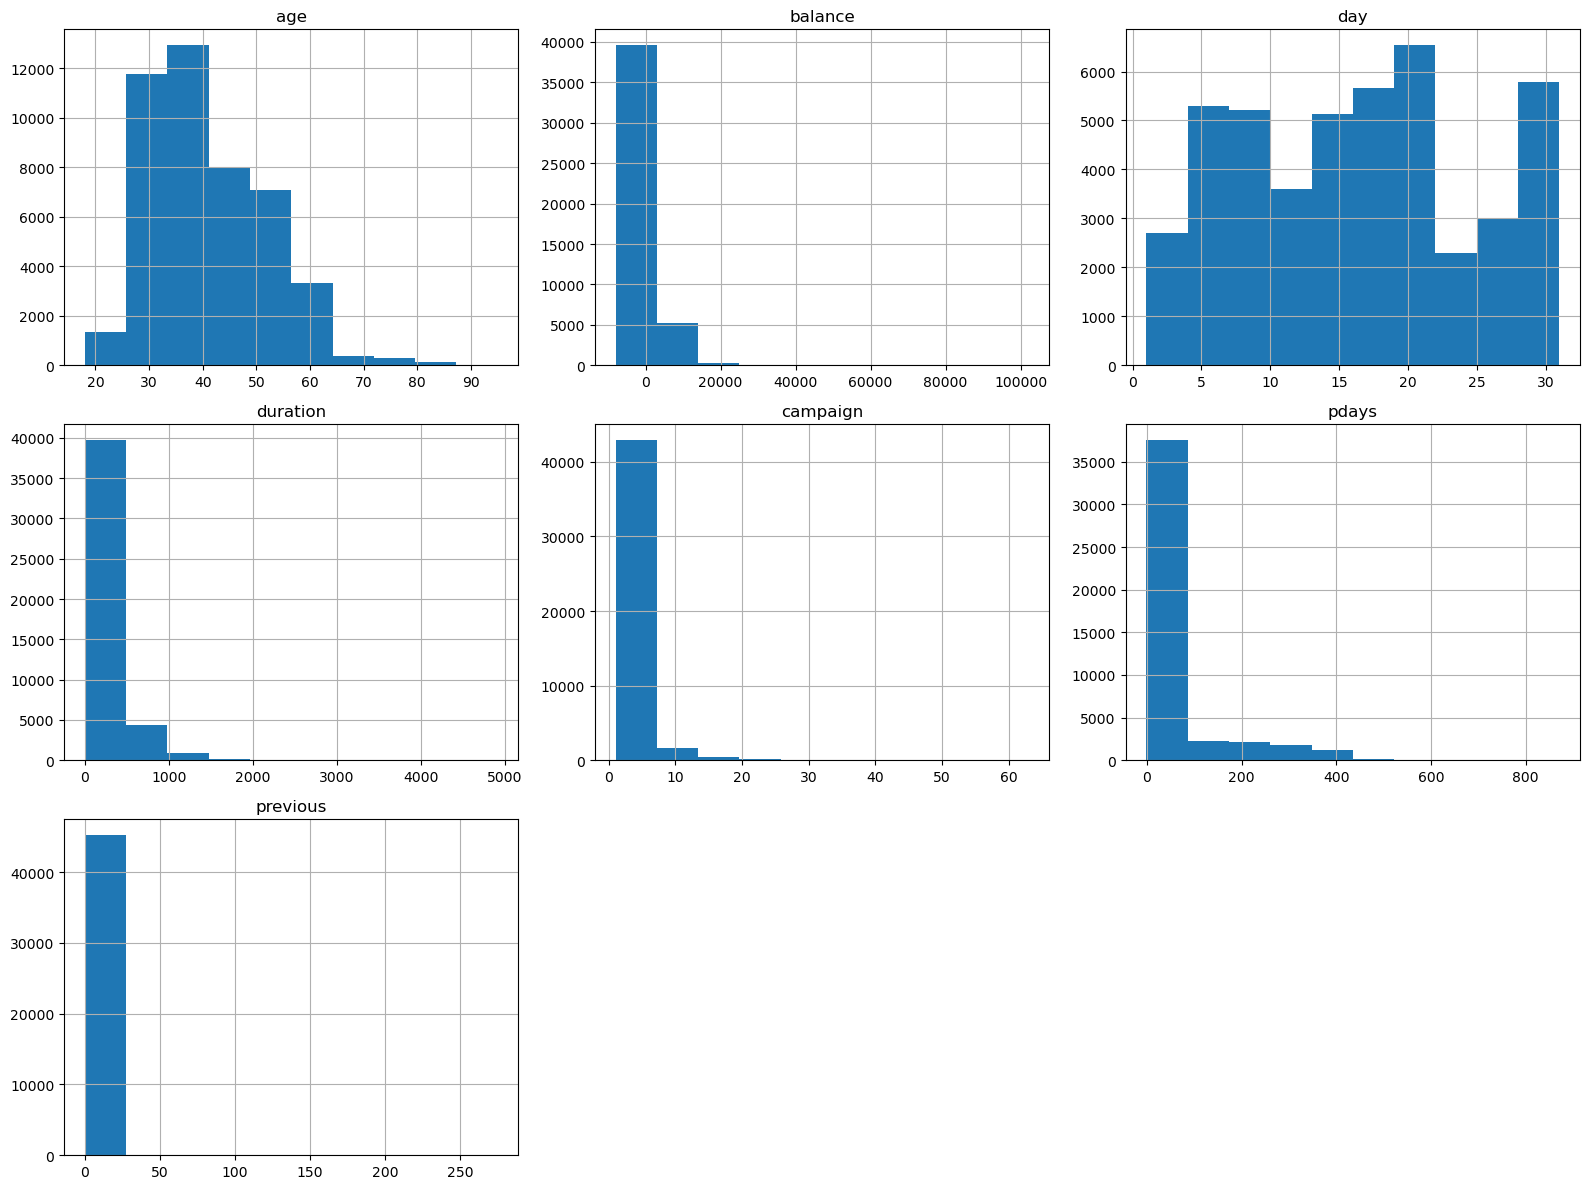

In [ ]:
# code here
df_num = df.select_dtypes(include = np.number)
rcParams['figure.figsize'] = 16,12
df.hist()
plt.tight_layout()

Use heatmap to display the numerical features' correlation

<Axes: >

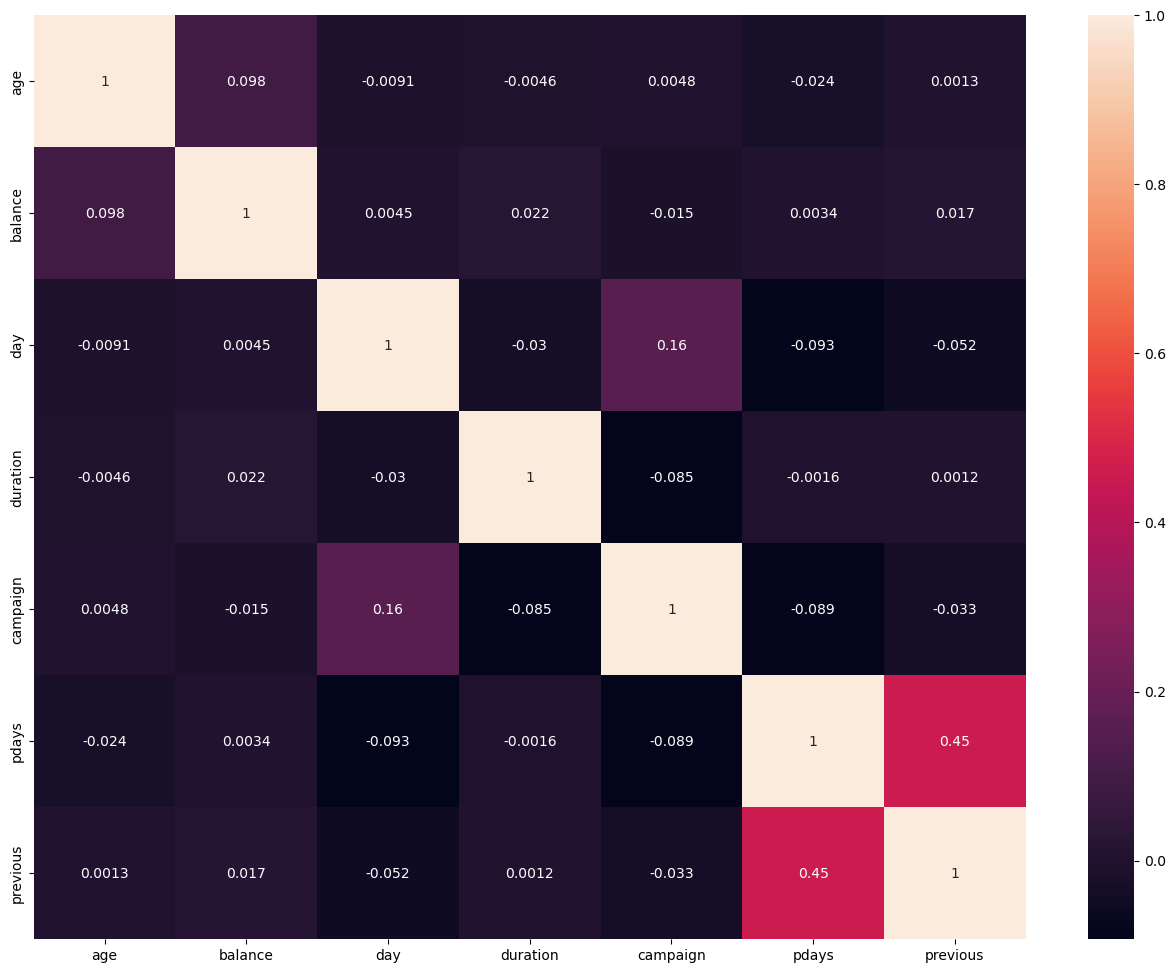

In [ ]:
# code here
sns.heatmap(df_num.corr(), annot = True)

The date is a strange type of data for machine learning. Think about it. Is the day? the month? the year that are important? Or the relative date for instance in the year?

If the phenomenon occurs seasonally, maybe it is better to look at the day of the year (on 365 days), if it monthly, maybe to look at the day in the month (on approximativally 30, 31 or other for bissextile year), etc... If more complex, well do the propoer hypothesis and test it.

For our problem, we supposed it is better to look at the day of the year. Maybe is good, maybe is wrong. It is an hypothesis we want you to test. So in order to continue the preprocessing, the features `day` and `month` should be merged into one column named `dayoftheyear`.

You can use pandas datetime tools or python datetime librairies for doing this preprocessing.
(the default year used will be 1984)

In [ ]:
#code here
def join_day_month(row):
    return str(row.day)+'/'+row.month + ' 1984'

df['dayoftheyear']= df.apply(join_day_month ,axis = 1)

In [ ]:
df['dayoftheyear'] = pd.to_datetime(df['dayoftheyear'])
df = df.drop(['day','month'],axis=1)

/tmp/ipykernel_28311/1169052726.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dayoftheyear'] = pd.to_datetime(df['dayoftheyear'])


In [ ]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,dayoftheyear
45206,51,technician,married,tertiary,no,825,no,no,cellular,977,3,-1,0,unknown,yes,1984-11-17
45207,71,retired,divorced,primary,no,1729,no,no,cellular,456,2,-1,0,unknown,yes,1984-11-17
45208,72,retired,married,secondary,no,5715,no,no,cellular,1127,5,184,3,success,yes,1984-11-17
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,508,4,-1,0,unknown,no,1984-11-17
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,361,2,188,11,other,no,1984-11-17


In [ ]:
df.nunique()

age               77
job               12
marital            3
education          4
default            2
balance         7168
housing            2
loan               2
contact            3
duration        1573
campaign          48
pdays            559
previous          41
poutcome           4
y                  2
dayoftheyear     318
dtype: int64

In [ ]:
len(df.columns)

16

We cannot treat the same way categories with numerical features. So let's make two different lists and different treatments. Now sort the features into categorical and numerical features

In [ ]:
categorical_features = ['job','marital','education','default','housing','loan','contact','poutcome'] # to be completed
numerical_features = ['age','balance','duration','campaign','pdays','previous'] # to be completed

In [ ]:
# Une autre facon de determiner les variables categorielles et quantitatives
categorical_features = df.columns[(df.nunique() < 20) & (df.columns != 'y')].tolist()
numerical_features = df.columns[(df.nunique() > 20) & (df.columns != 'y') & (df.columns != 'dayoftheyear')].tolist()
numerical_features

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

After a first exploration, categorical/ordinal features (10 columns) need to be encoded in order to become a valid input for the modeling phase. ML manipulates figures, not string, not category by itself.

Look at the encoder to *encode* your *categorical data*. The different encoders can be found [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

(You can also use the function `get_dummies` of pandas for categorical features)

In [ ]:
# Create the X and y DataFrames resample the dataframes if necessary
X = df.drop(['y','dayoftheyear'],axis = 1)
y = df['y']

In [ ]:
# import and create the appropriate transformers 
from sklearn.preprocessing import LabelEncoder,StandardScaler

le = LabelEncoder()

le.fit(y)
y = le.transform(y)
X = pd.get_dummies(X,columns = categorical_features)

scaler = StandardScaler().fit(X[numerical_features])
X_scaled = X.copy()

X_scaled[numerical_features] = scaler.transform(X[numerical_features]) 

At the end of this part, two dataframes are created :

- `X` containing the features (or the matrix $X$)
- `y` containing the label (or $ŷ$)

Display the shape of X and y

In [ ]:
# code here
print(f"{"""X's shape:""":-<150}{X_scaled.shape}")
print(f"{"""y's shape:""":-<150}{y.shape}")

X's shape:--------------------------------------------------------------------------------------------------------------------------------------------(45211, 38)
y's shape:--------------------------------------------------------------------------------------------------------------------------------------------(45211,)


Well done! The data is now ready to be splitted into sets and used to train models!

Hop hop hop!!! Not to fast!! You processed the data for machine learning, but are all the data useful?  
As an expert, I tell you you should removed the duration column!!

Could you tell me why?

💡*think first, but if you have no idea double click here.*
<!-- When do your calls last the most? --> 

In [ ]:
# remove duration column
X_scaled = X_scaled.drop(['duration'],axis=1)

## Modelling phase

The client needs two features :

1. A model, which can be updated without performance loss. In other word, it means a pipeline easy to use and evaluate.
2. A model, that performs well.

### Simple Decision Tree

We will experiment both feature by doing the two following steps.

* Training the Decision Tree model with various splits of the dataset (change the `seed` parameter of the `train_test_split` function for obtaining the second dataset)
* The decision tree `max_depth` will be fixed at 3 first

if you need more info you can take a look at the [sklearn decision tree doc](https://scikit-learn.org/stable/modules/tree.html).

In [ ]:
# Decision tree model creation and tree visualization
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X_scaled,y, test_size = 0.2, random_state=42)
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=3)

Now, a first model has been created, change the random seed for the train/test split, and create another tree.

This tree should be created with the same hyperparameters than above. 

In [ ]:
# create a new train and test dataset with a different seed
X_train_new, X_test_new, y_train_new,y_test_new = train_test_split(X_scaled,y, test_size = 0.2, random_state=41)


In [ ]:
# Second tree creation
tree_clf_new = DecisionTreeClassifier(max_depth=3)
tree_clf_new.fit(X_train_new,y_train_new)

DecisionTreeClassifier(max_depth=3)

What can you tell about the two trees?

*answer here*

The trees seems be the same.

Normally, before creating a model, one or more evaluation metrics should be chosen depending on the client problem.

* Choose different metrics that seem relevant to this problem (see previous lesson on Classification)

* Prepare a scoring list for these metrics.

* Use the cross-validation method to measure these metrics (if you need see : [cross validation sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)). 

*Hint:*  the `cross_validate` method allows you to pass a metric list as parameter (see [doc here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) ).

In [ ]:
# Cross validation on Decision trees
from sklearn.metrics import confusion_matrix,  precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_validate,StratifiedKFold
score_list = ['f1','average_precision','roc_auc']

scores_dtr1 = cross_validate(DecisionTreeClassifier(max_depth=3), X_train, y_train, cv=3,
                        scoring= score_list,
                        return_train_score=True)
scores_dtr2 = cross_validate(DecisionTreeClassifier(max_depth=3), X_train_new, y_train_new, cv=3,
                        scoring= score_list,
                        return_train_score=True)
scores_dtr2

{'fit_time': array([0.05694699, 0.05288959, 0.05273747]),
 'score_time': array([0.03902864, 0.03938723, 0.02775025]),
 'test_f1': array([0.23122765, 0.27338936, 0.30544638]),
 'train_f1': array([0.24318658, 0.29879922, 0.28203693]),
 'test_average_precision': array([0.27082438, 0.26137047, 0.29165545]),
 'train_average_precision': array([0.2824601 , 0.28686795, 0.26796329]),
 'test_roc_auc': array([0.68412681, 0.67540515, 0.69117507]),
 'train_roc_auc': array([0.68443706, 0.68875551, 0.68011514])}

In [ ]:
print(f'scores list for the first tree: {scores_dtr1['test_f1']}')
print(f'scores list for the second tree: {scores_dtr2['test_f1']}')

scores list for the first tree: [0.29252078 0.29078801 0.27673649]
scores list for the second tree: [0.23122765 0.27338936 0.30544638]


Now process the output of your cross-validation in order to know the diversity in performances and the average performance

Plot your metrics performance

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'fit_time'),
  Text(1, 0, 'score_time'),
  Text(2, 0, 'test_f1'),
  Text(3, 0, 'train_f1'),
  Text(4, 0, 'test_average_precision'),
  Text(5, 0, 'train_average_precision'),
  Text(6, 0, 'test_roc_auc'),
  Text(7, 0, 'train_roc_auc')])

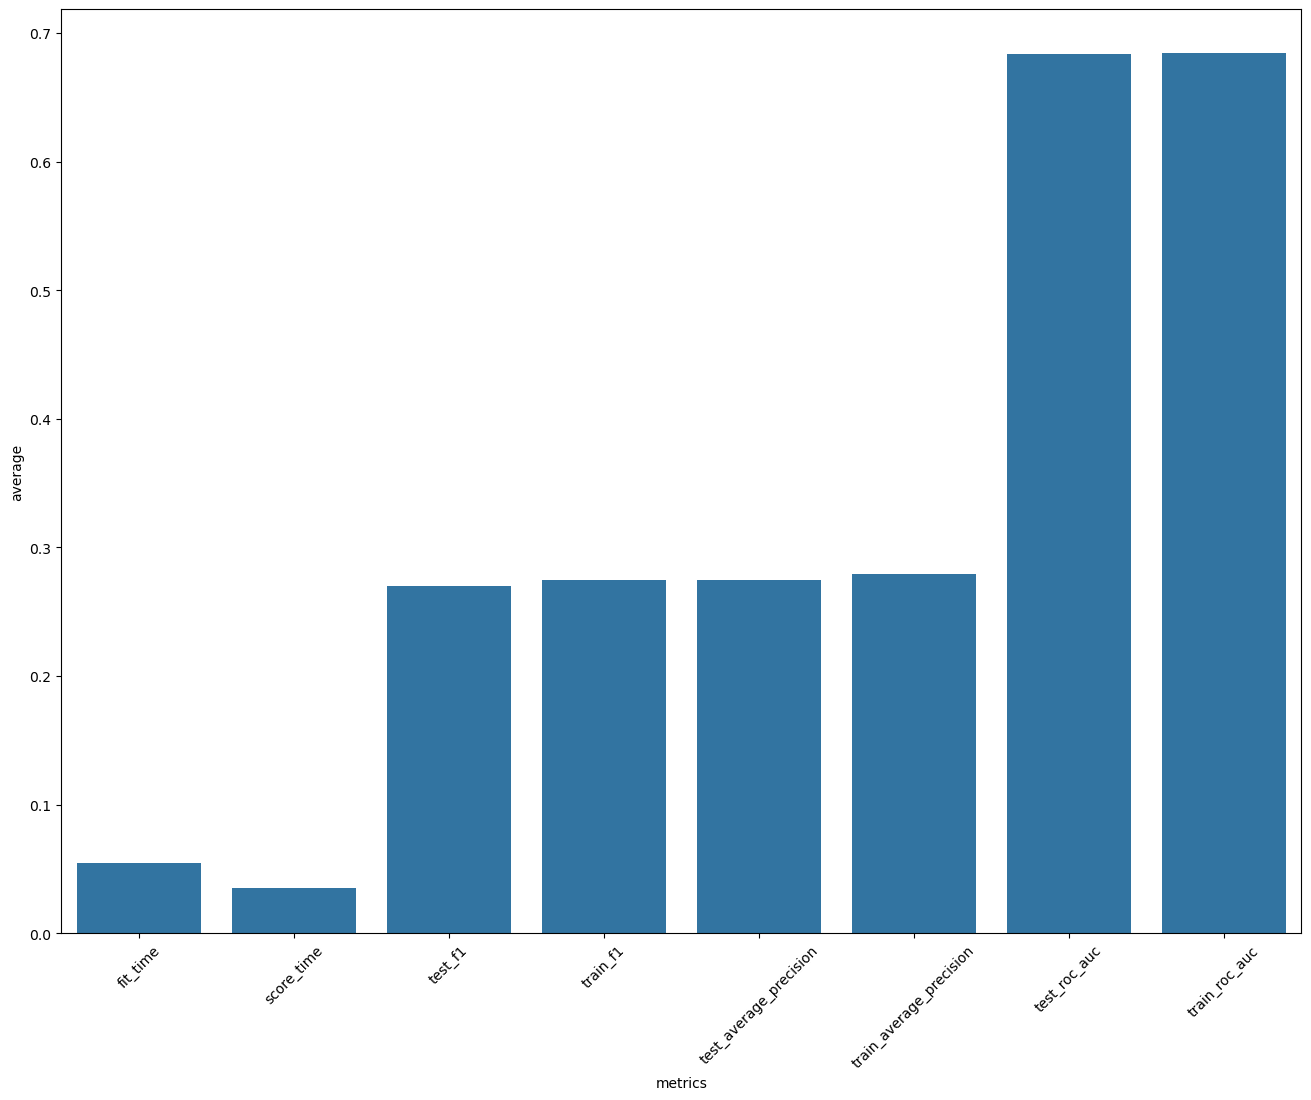

In [ ]:
dic_list = [scores_dtr1,scores_dtr2]
dic_score_decision_tree = pd.DataFrame()
modele_list = ['tree 1','tree 2']
for i in range(2):
    modele_name = modele_list[i]
    list_metrics =[]
    list_average = []
    list_std = []
    list_name = []
    for key, value in dic_list[i].items():
        list_metrics.append(key)
        list_average.append(np.mean(value))
        list_std.append(np.std(value))
        list_name.append(modele_name)
dic_score_decision_tree = pd.DataFrame({'modele_name':list_name,'metrics':list_metrics,'average':list_average,'standard_deviation':list_std})
sns.barplot(data = dic_score_decision_tree, x = 'metrics' , y ='average'  )
plt.xticks(rotation=45)

In [ ]:
dic_score_decision_tree.tail() 

,modele_name,metrics,average,standard_deviation
3,tree 2,train_f1,0.274674,0.023293
4,tree 2,test_average_precision,0.274617,0.012651
5,tree 2,train_average_precision,0.279097,0.008076
6,tree 2,test_roc_auc,0.683569,0.006450
7,tree 2,train_roc_auc,0.684436,0.003527


Now choose a single metric to perform a grid search on the `max_depth` of the tree.

In [ ]:
from sklearn.model_selection import KFold,GridSearchCV
param_grid = {'max_depth': [None,2,5, 6,10,15,18]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
grid_search_dtr = GridSearchCV(estimator=DecisionTreeClassifier(),cv=cv,param_grid=param_grid,scoring='f1',n_jobs = -1)
grid_search_dtr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 5, 6, 10, 15, 18]},
             scoring='f1')

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [ ]:
# Test metrics

dtr_final = grid_search_dtr.best_estimator_

y_test_pred_dtr = dtr_final.predict(X_test)

def evaluation_metrics(y_test,y_test_pred):
    matrice_confusion = confusion_matrix(y_test,y_test_pred)
    accuracy = accuracy_score(y_test_pred,y_test)
    precision = precision_score(y_test_pred,y_test)
    recall  = recall_score(y_test_pred,y_test)
    f1score  = f1_score(y_test_pred,y_test)
    print(f"{'accuracy':-<150}{accuracy}")
    print(f"{'precision':-<150}{precision}")
    print(f"{'recall':-<150}{recall}")
    print(f"{'f1 score':-<150}{f1score }")
    print(f'matrice de confusion:\n\n{matrice_confusion}')

evaluation_metrics(y_test,y_test_pred_dtr)

accuracy----------------------------------------------------------------------------------------------------------------------------------------------0.8907442220502045
precision---------------------------------------------------------------------------------------------------------------------------------------------0.1851512373968836
recall------------------------------------------------------------------------------------------------------------------------------------------------0.6710963455149501
f1 score----------------------------------------------------------------------------------------------------------------------------------------------0.29022988505747127
matrice de confusion:

[[7853   99]
 [ 889  202]]


What are your observation?  
By looking at the metric results, what is strange? Or at the opposite, obvious?

From theses observations, what are your conclusions?  
In the next sessions, we will look at ensembling to improve performances. But what should you be suspicious? What are the potential risks you identified?  

Propose something, continue to the next section and change your conclusions if you need.

### Introducing Ensemble Learning with Bagging models.

Let's train multiple classifiers in parallel in a bootstraping approach! 

Bagging stands for ***Boostrap AGGregatING***.

The following [post](https://blog.octo.com/les-methodes-ensemblistes-pour-algorithmes-de-machine-learning/) will give you an overview of these methods and their advantages and drawbacks

**The train test split using a seed equals to 42 will be used in the following part**

In [ ]:
# train_test split (you can copy paste the previously declared cell)
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.2, random_state=42)


#### Using Random Forest

The concept of random forest is explained in this [post](https://medium.com/analytics-vidhya/understanding-the-random-forest-algorithm-79b87bdde79a).

Now the best parameters of the previous classifier will be used in a using a bagging classifier
[sklearn : Random Forest Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

We will use grid search on the `n_estimators` and `max_depth` parameters. 

In [ ]:
# gridsearch for the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [None,2,5, 6,10,15,18], 'n_estimators': [100, 200, 300,400,500,600]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
grid_search = GridSearchCV(estimator=RandomForestClassifier(),cv=cv, param_grid=param_grid,scoring='f1',n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 5, 6, 10, 15, 18],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             scoring='f1')

How much estimators should we use for obtaining an optimal result? (in terms of time and performance)

*answer here*

time = 7 min 15 s

n_estimators = 600 

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [ ]:
# Test metrics

random_forest = grid_search.best_estimator_

y_test_pred = random_forest.predict(X_test)

evaluation_metrics(y_test,y_test_pred)


accuracy----------------------------------------------------------------------------------------------------------------------------------------------0.884662169633971
precision---------------------------------------------------------------------------------------------------------------------------------------------0.21448212648945922
recall------------------------------------------------------------------------------------------------------------------------------------------------0.5571428571428572
f1 score----------------------------------------------------------------------------------------------------------------------------------------------0.30972865651886167
matrice de confusion:

[[7766  186]
 [ 857  234]]


#### Other Random Forest effect

The random forest model can attribute an importance value to features, [explanations here](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

Let's train another random forest and display an histogramm with it :

In [ ]:
# training and display features' importance.
# tell them to use the RandomForest Object

importances=random_forest.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_scaled.columns, 'Importance': importances}).sort_values('Importance', ascending=False) 


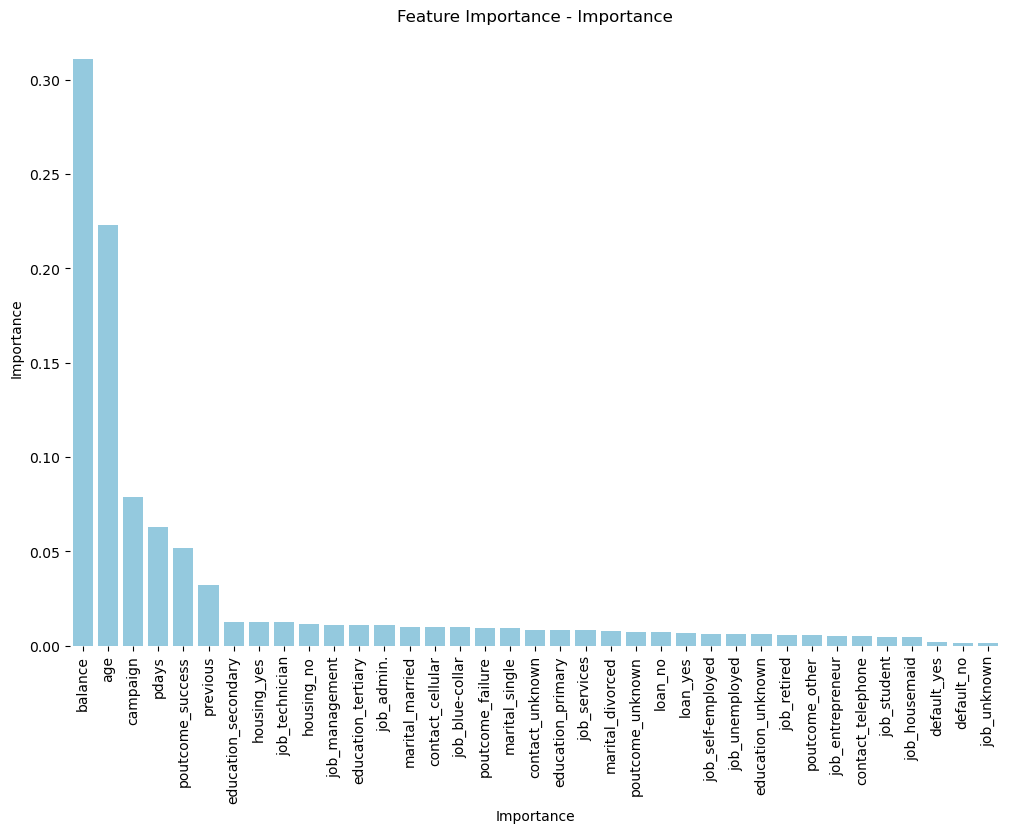

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(feature_imp_df, x = 'Feature',y = 'Importance' , color='skyblue')
plt.xlabel('Importance')

plt.title('Feature Importance - Importance')
#plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.xticks(rotation = 90)
sns.despine(left=True, bottom=True)
plt.show()


What is the most important feature?

*Answer here*

A lot of features have low importance and probably add noise which reduce the performance of the classifier, do a feature selection by recursive elemination to automatically select the subset of features that gives you the best model predictions.

You can have a look at : 

https://scikit-learn.org/stable/modules/feature_selection.html

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [ ]:
# Feature selection with recursive elimination
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier())
rfe.fit(X_train, y_train)
# Transform the dataset
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [ ]:
# Do another grid search on your model with the subset of selected features
param_grid = {'max_depth': [None,2,5, 6,10,15,18], 'n_estimators': [100, 200, 300,400,500,600]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
grid_search = GridSearchCV(estimator=RandomForestClassifier(),cv=cv, param_grid=param_grid,scoring='f1',n_jobs = -1)
grid_search.fit(X_train_rfe, y_train)

KeyboardInterrupt: 

We removed the duration feature in our dataset

Read this feature description on the dataset description ([here on data.world](https://data.world/uci/bank-marketing) or [here on kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset)).

How would the previously trained models perform with this feature?

*Answer here*

### Continue Ensemble Learning with boosting techniques

Bagging permits to average the results of separated models, whereas the boosting technique trains a classifier and optimizes it in function of its error.

Some information about boosting techniques are on the [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) but a commonly used library for these techniques is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) there are some compatibilities with the sklearn methods (gridsearch, cross validation,...)

- install the `xgboost` package

*Read the articles in resources for a complete explanation.*

In this part a classifier will be trained and evaluated.

In [ ]:
# use the same split and seed than you used before
# normally, you have nothing to code here :D 



*Hint:* An example for integrating `XGBoost` with  the `sklearn` tools is available [here](https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a)

In [ ]:
import xgboost as xgb

Let's build a new model than before with a grid search on the `n_estimators` and `max_depth` parameters.

In [ ]:
# model building and evaluation


param_grid = {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    
  }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),cv=cv, param_grid=param_grid,scoring='f1',n_jobs = -1)
grid_search.fit(X_train, y_train)


/home/fabrice.paka@Digital-Grenoble.local/anaconda3/envs/mon_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:42] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/home/fabrice.paka@Digital-Grenoble.local/anaconda3/envs/mon_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:42] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/home/fabrice.paka@Digital-Grenoble.local/anaconda3/envs/mon_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:42] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "clf__learning_rate", "clf__max_depth", "clf__n_estimators" } are not used.

  warnings.warn(smsg, UserWarn

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'clf__max_depth': range(3, 10),
                         'clf__n_estimators': [50, 100, 150, 200]},
             scoring='f1')

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [ ]:
# Test metrics
xgb_model = grid_search.best_estimator_
y_test_pred_xgb = xgb_model.predict(X_test)
evaluation_metrics(y_test,y_test_pred_xgb)


accuracy----------------------------------------------------------------------------------------------------------------------------------------------0.8883114010837112
precision---------------------------------------------------------------------------------------------------------------------------------------------0.18790100824931255
recall------------------------------------------------------------------------------------------------------------------------------------------------0.6231003039513677
f1 score----------------------------------------------------------------------------------------------------------------------------------------------0.2887323943661972
matrice de confusion:

[[7828  124]
 [ 886  205]]


In [ ]:
# performance curves
xgb_model

## Let's Conclude

Report your test set metrics for the three methods here

In [ ]:
# Decision Tree on test set


In [ ]:
# Random forest on test set

In [ ]:
# XGBoost on test set

What do you notice? What are you real conclusion about the dataset? What should you tell the client about the dataset and his problem?

*answer here*

- Write your memo about bagging and boosting method in a cell below.
- Which model would you choose for the bank, and why? Which precautions?

you can add your models result visualization in this cell if it helps you explaining your conclusions.

                                 `write memo here`

## To go further

### Build a customized bagging classifier (Optional) 

- Use a different classification model you have seen until now and build a new classifier based on the [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) to create and train an new model.
- Use differents classification models and use the [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) to create and train a new model.

In [ ]:
# Write your code here

## Rebalance the data if you haven't done it yet

Before going through the modelling phase, let's see the label distribution :

Use the `value_counts` function and the appropriate visualization for displaying the label distribution

In [ ]:
# code here

What do you notice?

*answer here*

The easiest way to rebalance your data is to add the `class_weight='balanced'` parameter to your scikit learn model. The `class_weight` parameter is available in most scikit-learn models, for example look at the Decision Trees doc :
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

(There are other techniques for rebalancing the data [here](https://blog.octo.com/donnees-desequilibrees-que-faire/), [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) ).

Rebalance the data with the `class_weight` parameter, and you'll have much better f1 and Average Precision metrics.

In [ ]:
# code here